In [1]:
import itertools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ventilation_wall as vw
import ventilation_wall_simplified as vws
import envelope_performance_factors
import global_number

# 通気層を有する壁体等の熱的性能のケーススタディ

## 検討用パラメータを設定

### 分析用パラメータのリストを作成

In [2]:
# 通気層の平均風速, m/s
v_a_array = np.arange(0.0, 2.0, 0.05)
v_a_array

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95])

In [3]:
# 外気側表面に入射する日射量, W/m2
j_surf_array = np.array([0.0, 500.0, 1000.0])
j_surf_array

array([   0.,  500., 1000.])

In [4]:
# 外気側表面日射吸収率
a_surf_array = np.array([0.0, 0.5, 1.0])
a_surf_array

array([0. , 0.5, 1. ])

In [5]:
# 外気側部材の熱コンダクタンス,W/(m2・K)
C_1_array = np.arange(0.5, 50.5, 1.5)
C_1_array

array([ 0.5,  2. ,  3.5,  5. ,  6.5,  8. ,  9.5, 11. , 12.5, 14. , 15.5,
       17. , 18.5, 20. , 21.5, 23. , 24.5, 26. , 27.5, 29. , 30.5, 32. ,
       33.5, 35. , 36.5, 38. , 39.5, 41. , 42.5, 44. , 45.5, 47. , 48.5,
       50. ])

In [6]:
# 通気層に面する面2の放射率
#emissivity_2_array = np.array([0.1, 0.5, 0.9])
emissivity_2_array = np.arange(0.05, 1.05, 0.05)
emissivity_2_array

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

## 分析用の関数を定義
### パラメータリストを作成する関数

In [7]:
def getParameterList(arg_theta_e: float, arg_theta_r: float,
                     v_a_array: np.array, j_surf_array: np.array, a_surf_array: np.array,
                    C_1_array: np.array, emissivity_2_array: np.array) -> pd.DataFrame:
    
    # 風速、日射量、日射吸収率の直積を作成し、DataFrameに変換
    parameter_list = list(itertools.product(v_a_array, j_surf_array, a_surf_array, C_1_array, emissivity_2_array))
    df = pd.DataFrame(parameter_list, columns=['v_a', 'j_surf', 'a_surf', 'C_1', 'emissivity_2'])
    
    # その他のパラメータの値を設定
    df['theta_e'] = arg_theta_e
    df['theta_r'] = arg_theta_r
    df['C_2'] = 2.55
    df['l_h'] = 7.5
    df['l_w'] = 5.025
    df['l_d'] = 0.175
    df['angle'] = 45.0
    df['l_s'] = 0.45
    df['emissivity_1'] = 0.9

    return df


### 簡易計算法案No.3による計算結果を保有するDataFrameを作成する関数

In [8]:
def get_wall_status_data_by_simplified_calculation_no_03(df: pd.DataFrame) -> pd.DataFrame:

    # 固定値の設定
    h_out = global_number.get_h_out()

    # 計算結果格納用配列を用意
    u_dash = []
    eta_dash = []
    q_room_side = []

    for row in df.itertuples():
        # パラメータを設定
        parms = (vw.Parameters(theta_e=row.theta_e, theta_r=row.theta_r, J_surf=row.j_surf, a_surf=row.a_surf,
                               C_1=row.C_1, C_2=row.C_2, l_h=row.l_h, l_w=row.l_w, l_d=row.l_d, angle=row.angle,
                               v_a=row.v_a, l_s=row.l_s, emissivity_1=row.emissivity_1, emissivity_2=row.emissivity_2
                              )
                )

        # 対流熱伝達率、放射熱伝達率、修正熱貫流率、修正日射熱取得率、室内側表面熱流を計算
        h_cv_buf, h_rv_buf, u_dash_buf, eta_dash_buf, q_room_side_buf = vws.get_vent_wall_performance_factor_by_simplified_calculation_no_03(parm=parms, h_out=h_out)

        # 配列に格納
        u_dash.append(u_dash_buf)
        eta_dash.append(eta_dash_buf)
        q_room_side.append(q_room_side_buf)

    # 計算結果をDataFrameに追加
    df['u_dash'] = u_dash
    df['eta_dash'] = eta_dash
    df['q_room_side'] = q_room_side

    return df


### 散布図を作成する関数（凡例あり）

In [9]:
def setPltComparison(df: pd.DataFrame, fig_title:str, x_label:str, y_label:str,
                     x_data_name: str, y_data_name: str,
                     query_label:str, query_data_name: str, query_data_list: np.array,
                     xlim_min:float, xlim_max:float, ylim_min:float, ylim_max:float):
    
    # グラフを表示する領域（figureオブジェクト）、グラフを描画する領域（Axesオブジェクト）を作成
    # グラフサイズを指定する　デフォルト：figsize=(6.4, 4.8)、小サイズ：figsize=(4.0, 3.5)
    fig, ax = plt.subplots(figsize=(6.4, 4.8))
    
    # フォントサイズを設定
    plt.rcParams["font.size"] = 14
    
    # グラフタイトルを設定
    fig.suptitle(fig_title)
        
    # 補助軸の設定
    ax.grid(which='major', color='gray', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle='-')
        
    # 軸ラベルの設定
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # プロットの色を設定
    colors =['b', 'g', 'r']
    
    # 散布図の描画設定
    for i, data in enumerate(query_data_list):
        x = df.query(query_data_name + ' == ' + str(query_data_list[i]))[x_data_name]
        y = df.query(query_data_name + ' == ' + str(query_data_list[i]))[y_data_name]
        label = query_label + ':' + str(query_data_list[i])
        ax.scatter(x, y, color=colors[i], label= label, s=30, marker=".")
        
    # 軸の描画範囲設定
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    
    # グラフ描画
    plt.legend()
    plt.show()
    

### 散布図を作成する関数（凡例なし）

In [10]:
def setPltComparison_NoLegend(df: pd.DataFrame, fig_title:str, x_label:str, y_label:str,
                     x_data_name: str, y_data_name: str, x_scale_interval: float,
                     xlim_min:float, xlim_max:float, ylim_min:float, ylim_max:float):
    
    # グラフを表示する領域（figureオブジェクト）、グラフを描画する領域（Axesオブジェクト）を作成
    # グラフサイズを指定する　デフォルト：figsize=(6.4, 4.8)、小サイズ：figsize=(4.0, 3.5)
    fig, ax = plt.subplots(figsize=(3.5, 3.2))
    
    # フォントサイズを設定
    plt.rcParams["font.size"] = 14
    
    # グラフタイトルを設定
    fig.suptitle(fig_title)
        
    # 補助軸の設定
    ax.grid(which='major', color='gray', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle='-')
        
    # 軸ラベルの設定
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # グラフの描画設定
    x = df[x_data_name]
    y = df[y_data_name]
    plt.plot(x, y, color='b', )
    
    # 軸の描画範囲設定
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    
    # 横軸の間隔を調整
    plt.xticks(np.arange(xlim_min, xlim_max+x_scale_interval, x_scale_interval))
    
    # グラフ描画
    plt.show()
    

## グラフの描画
### 冬期条件のDataFrameを作成

In [11]:
df_winter = get_wall_status_data_by_simplified_calculation_no_03(
    getParameterList(arg_theta_e=-10.0, arg_theta_r=20.0, v_a_array=v_a_array, j_surf_array=j_surf_array,
                     a_surf_array=a_surf_array, C_1_array=C_1_array, emissivity_2_array=emissivity_2_array)
)
df_winter

,v_a,j_surf,a_surf,C_1,emissivity_2,theta_e,theta_r,C_2,l_h,l_w,l_d,angle,l_s,emissivity_1,u_dash,eta_dash,q_room_side
0,0.00,0.0,0.0,0.5,0.05,-10.0,20.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,0.307089,0.000000,-9.212684
1,0.00,0.0,0.0,0.5,0.10,-10.0,20.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,0.317559,0.000000,-9.526780
2,0.00,0.0,0.0,0.5,0.15,-10.0,20.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,0.325679,0.000000,-9.770373
3,0.00,0.0,0.0,0.5,0.20,-10.0,20.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,0.332160,0.000000,-9.964805
4,0.00,0.0,0.0,0.5,0.25,-10.0,20.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,0.337453,0.000000,-10.123596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244795,1.95,1000.0,1.0,50.0,0.80,-10.0,20.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,1.714952,0.013696,-37.752889
244796,1.95,1000.0,1.0,50.0,0.85,-10.0,20.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,1.717774,0.014095,-37.438296
244797,1.95,1000.0,1.0,50.0,0.90,-10.0,20.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,1.720473,0.014477,-37.137451
244798,1.95,1000.0,1.0,50.0,0.95,-10.0,20.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,1.723056,0.014842,-36.849472


### 冬期条件：風速による影響の確認
#### 室内表面熱流

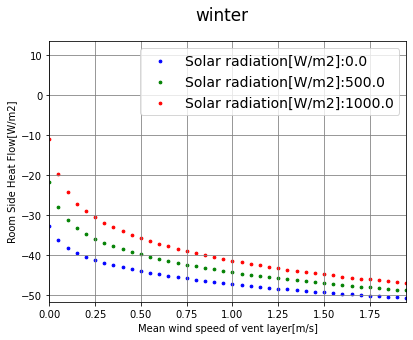

In [12]:
# 分析条件を固定
df = df_winter.query("a_surf == 0.5 & C_1 == 11.0 & emissivity_2 == 0.5")
# グラフ描画
setPltComparison(df=df, fig_title='winter',
                 x_label='Mean wind speed of vent layer[m/s]',
                 y_label='Room Side Heat Flow[W/m2]',
                 x_data_name='v_a', y_data_name='q_room_side',
                 query_label='Solar radiation[W/m2]',
                 query_data_name='j_surf',
                 query_data_list=j_surf_array,
                 xlim_min=min(v_a_array), xlim_max=max(v_a_array),
                 ylim_min=df_winter['q_room_side'].min(), ylim_max=df_winter['q_room_side'].max()
                )

#### 修正熱貫流率、修正日射熱取得率

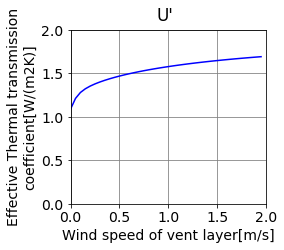

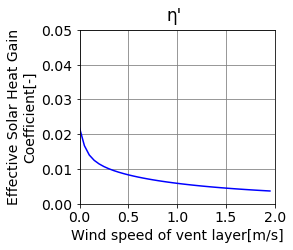

In [13]:
# 分析条件を固定
df = df_winter.query("a_surf == 0.5 & j_surf == 1000.0  & C_1 == 11.0 & emissivity_2 == 0.5")
# グラフ描画
setPltComparison_NoLegend(df=df, fig_title='U\'',
                 x_label='Wind speed of vent layer[m/s]',
                 y_label='Effective Thermal transmission\ncoefficient[W/(m2K)]',
                 x_data_name='v_a', y_data_name='u_dash',
                 x_scale_interval = 0.5,
                 xlim_min=0.0, xlim_max=2.0,
                 ylim_min=0.0, ylim_max=2.0
                )
# グラフ描画
setPltComparison_NoLegend(df=df, fig_title='η\'',
                 x_label='Wind speed of vent layer[m/s]',
                 y_label='Effective Solar Heat Gain\nCoefficient[-]',
                 x_data_name='v_a', y_data_name='eta_dash',
                 x_scale_interval = 0.5,
                 xlim_min=0.0, xlim_max=2.0,
                 ylim_min=0.0, ylim_max=0.05
                )

### 冬期条件：外気側部材の熱コンダクタンスによる影響の確認
#### 室内表面熱流

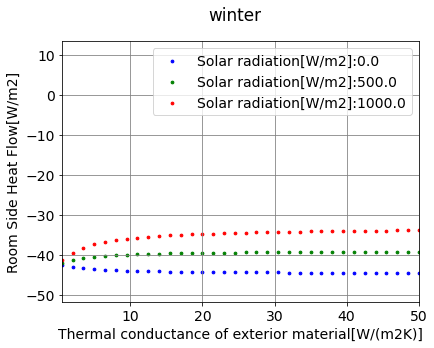

In [14]:
# 分析条件を固定
df = df_winter.query("a_surf == 0.5 & v_a == 0.5 & emissivity_2 == 0.5")
# グラフ描画
setPltComparison(df=df, fig_title='winter',
                 x_label='Thermal conductance of exterior material[W/(m2K)]',
                 y_label='Room Side Heat Flow[W/m2]',
                 x_data_name='C_1', y_data_name='q_room_side',
                 query_label='Solar radiation[W/m2]',
                 query_data_name='j_surf',
                 query_data_list=j_surf_array,
                 xlim_min=min(C_1_array), xlim_max=max(C_1_array),
                 ylim_min=df_winter['q_room_side'].min(), ylim_max=df_winter['q_room_side'].max()
                )

#### 修正熱貫流率、修正日射熱取得率

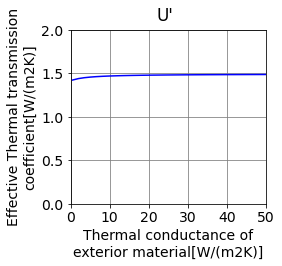

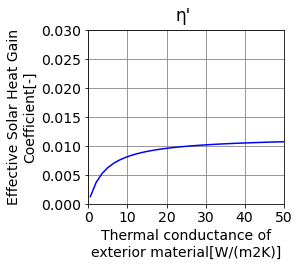

In [15]:
# 分析条件を固定
df = df_winter.query("a_surf == 0.5 & j_surf == 1000.0  & v_a == 0.5 & emissivity_2 == 0.5")
# グラフ描画
setPltComparison_NoLegend(df=df, fig_title='U\'',
                 x_label='Thermal conductance of\nexterior material[W/(m2K)]',
                 y_label='Effective Thermal transmission\ncoefficient[W/(m2K)]',
                 x_data_name='C_1', y_data_name='u_dash',
                 x_scale_interval = 10.0,
                 xlim_min=0.0, xlim_max=50.0,
                 ylim_min=0.0, ylim_max=2.0
                )
# グラフ描画
setPltComparison_NoLegend(df=df, fig_title='η\'',
                 x_label='Thermal conductance of\nexterior material[W/(m2K)]',
                 y_label='Effective Solar Heat Gain\nCoefficient[-]',
                 x_data_name='C_1', y_data_name='eta_dash',
                 x_scale_interval = 10.0,
                 xlim_min=0.0, xlim_max=50.0,
                 ylim_min=0.0, ylim_max=0.03
                )

### 冬期条件：通気層に面する面2の放射率による影響の確認
#### 室内表面熱流

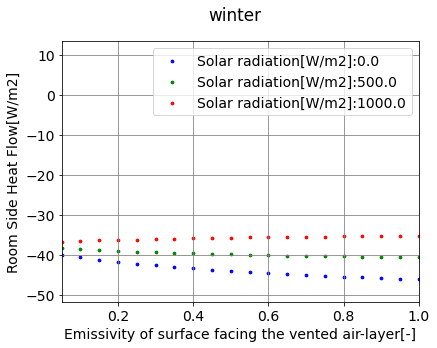

In [16]:
# 分析条件を固定
df = df_winter.query("a_surf == 0.5 & v_a == 0.5 & C_1 == 11.0")
# グラフ描画
setPltComparison(df=df, fig_title='winter',
                 x_label='Emissivity of surface facing the vented air-layer[-]',
                 y_label='Room Side Heat Flow[W/m2]',
                 x_data_name='emissivity_2', y_data_name='q_room_side',
                 query_label='Solar radiation[W/m2]',
                 query_data_name='j_surf',
                 query_data_list=j_surf_array,
                 xlim_min=min(emissivity_2_array), xlim_max=max(emissivity_2_array),
                 ylim_min=df_winter['q_room_side'].min(), ylim_max=df_winter['q_room_side'].max()
                )

#### 修正熱貫流率、修正日射熱取得率

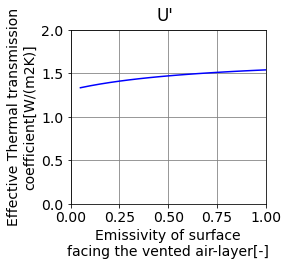

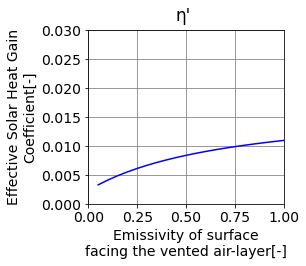

In [17]:
# 分析条件を固定
df = df_winter.query("a_surf == 0.5 & j_surf == 1000.0  & v_a == 0.5 & C_1 == 11.0")
# グラフ描画
setPltComparison_NoLegend(df=df, fig_title='U\'',
                 x_label='Emissivity of surface\nfacing the vented air-layer[-]',
                 y_label='Effective Thermal transmission\ncoefficient[W/(m2K)]',
                 x_data_name='emissivity_2', y_data_name='u_dash',
                 x_scale_interval = 0.25,
                 xlim_min=0.0, xlim_max=1.0,
                 ylim_min=0.0, ylim_max=2.0
                )
# グラフ描画
setPltComparison_NoLegend(df=df, fig_title='η\'',
                 x_label='Emissivity of surface\nfacing the vented air-layer[-]',
                 y_label='Effective Solar Heat Gain\nCoefficient[-]',
                 x_data_name='emissivity_2', y_data_name='eta_dash',
                 x_scale_interval = 0.25,
                 xlim_min=0.0, xlim_max=1.0,
                 ylim_min=0.0, ylim_max=0.03
                )

### 夏期条件のDataFrameを作成

In [18]:
df_summer = get_wall_status_data_by_simplified_calculation_no_03(
    getParameterList(arg_theta_e=35.0, arg_theta_r=27.0, v_a_array=v_a_array, j_surf_array=j_surf_array,
                     a_surf_array=a_surf_array, C_1_array=C_1_array, emissivity_2_array=emissivity_2_array)
)
df_summer

,v_a,j_surf,a_surf,C_1,emissivity_2,theta_e,theta_r,C_2,l_h,l_w,l_d,angle,l_s,emissivity_1,u_dash,eta_dash,q_room_side
0,0.00,0.0,0.0,0.5,0.05,35.0,27.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,0.299161,0.000000,2.393291
1,0.00,0.0,0.0,0.5,0.10,35.0,27.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,0.314694,0.000000,2.517550
2,0.00,0.0,0.0,0.5,0.15,35.0,27.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,0.325718,0.000000,2.605742
3,0.00,0.0,0.0,0.5,0.20,35.0,27.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,0.333947,0.000000,2.671580
4,0.00,0.0,0.0,0.5,0.25,35.0,27.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,0.340326,0.000000,2.722607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244795,1.95,1000.0,1.0,50.0,0.80,35.0,27.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,1.720857,0.016596,30.362733
244796,1.95,1000.0,1.0,50.0,0.85,35.0,27.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,1.724088,0.017041,30.833277
244797,1.95,1000.0,1.0,50.0,0.90,35.0,27.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,1.727156,0.017463,31.279974
244798,1.95,1000.0,1.0,50.0,0.95,35.0,27.0,2.55,7.5,5.025,0.175,45.0,0.45,0.9,1.730071,0.017864,31.704594


### 夏期条件：風速による影響の確認
#### 室内表面熱流

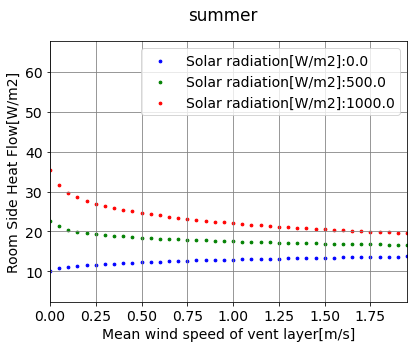

In [19]:
# 分析条件を固定
df = df_summer.query("a_surf == 0.5 & C_1 == 11.0 & emissivity_2 > 0.90 & emissivity_2 < 0.95")
# グラフ描画
setPltComparison(df=df, fig_title='summer',
                 x_label='Mean wind speed of vent layer[m/s]',
                 y_label='Room Side Heat Flow[W/m2]',
                 x_data_name='v_a', y_data_name='q_room_side',
                 query_label='Solar radiation[W/m2]',
                 query_data_name='j_surf',
                 query_data_list=j_surf_array,
                 xlim_min=min(v_a_array), xlim_max=max(v_a_array),
                 ylim_min=df_summer['q_room_side'].min(), ylim_max=df_summer['q_room_side'].max()
                )

#### 修正熱貫流率、修正日射熱取得率

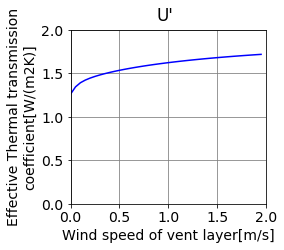

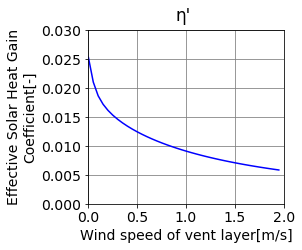

In [20]:
# 分析条件を固定
df = df_summer.query("a_surf == 0.5 & j_surf == 1000.0  & C_1 == 11.0 & emissivity_2 > 0.90 & emissivity_2 < 0.95")
# グラフ描画
setPltComparison_NoLegend(df=df, fig_title='U\'',
                 x_label='Wind speed of vent layer[m/s]',
                 y_label='Effective Thermal transmission\ncoefficient[W/(m2K)]',
                 x_data_name='v_a', y_data_name='u_dash',
                 x_scale_interval = 0.5,
                 xlim_min=0.0, xlim_max=2.0,
                 ylim_min=0.0, ylim_max=2.0
                )
# グラフ描画
setPltComparison_NoLegend(df=df, fig_title='η\'',
                 x_label='Wind speed of vent layer[m/s]',
                 y_label='Effective Solar Heat Gain\nCoefficient[-]',
                 x_data_name='v_a', y_data_name='eta_dash',
                 x_scale_interval = 0.5,
                 xlim_min=0.0, xlim_max=2.0,
                 ylim_min=0.0, ylim_max=0.03
                )

### 夏期条件：外気側部材の熱コンダクタンスによる影響の確認
#### 室内表面熱流

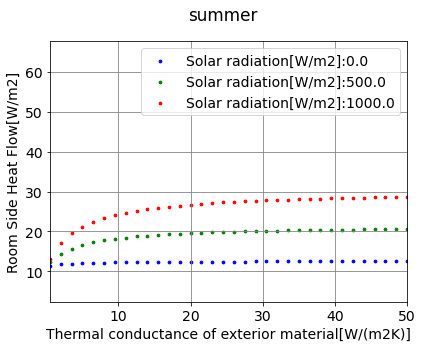

In [21]:
# 分析条件を固定
df = df_summer.query("a_surf == 0.5 & v_a == 0.5 & emissivity_2 > 0.90 & emissivity_2 < 0.95")
# グラフ描画
setPltComparison(df=df, fig_title='summer',
                 x_label='Thermal conductance of exterior material[W/(m2K)]',
                 y_label='Room Side Heat Flow[W/m2]',
                 x_data_name='C_1', y_data_name='q_room_side',
                 query_label='Solar radiation[W/m2]',
                 query_data_name='j_surf',
                 query_data_list=j_surf_array,
                 xlim_min=min(C_1_array), xlim_max=max(C_1_array),
                 ylim_min=df_summer['q_room_side'].min(), ylim_max=df_summer['q_room_side'].max()
                )

#### 修正熱貫流率、修正日射熱取得率

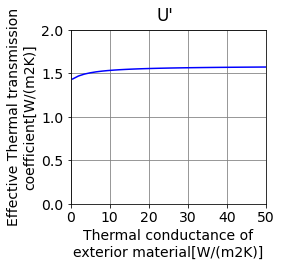

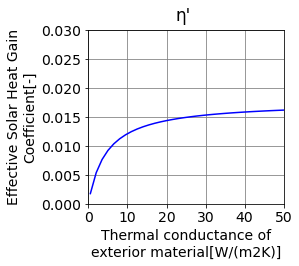

In [22]:
# 分析条件を固定
df = df_summer.query("a_surf == 0.5 & j_surf == 1000.0  & v_a == 0.5 & emissivity_2 > 0.90 & emissivity_2 < 0.95")
# グラフ描画
setPltComparison_NoLegend(df=df, fig_title='U\'',
                 x_label='Thermal conductance of\nexterior material[W/(m2K)]',
                 y_label='Effective Thermal transmission\ncoefficient[W/(m2K)]',
                 x_data_name='C_1', y_data_name='u_dash',
                 x_scale_interval = 10.0,
                 xlim_min=0.0, xlim_max=50.0,
                 ylim_min=0.0, ylim_max=2.0
                )
# グラフ描画
setPltComparison_NoLegend(df=df, fig_title='η\'',
                 x_label='Thermal conductance of\nexterior material[W/(m2K)]',
                 y_label='Effective Solar Heat Gain\nCoefficient[-]',
                 x_data_name='C_1', y_data_name='eta_dash',
                 x_scale_interval = 10.0,
                 xlim_min=0.0, xlim_max=50.0,
                 ylim_min=0.0, ylim_max=0.03
                )

### 夏期条件：通気層に面する面2の放射率による影響の確認
#### 室内表面熱流

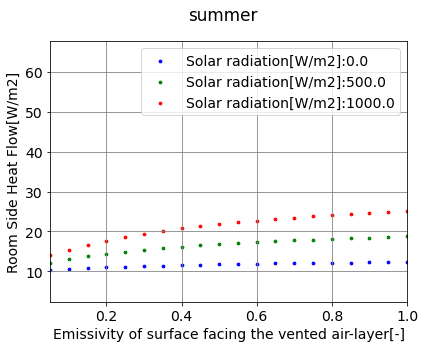

In [23]:
# 分析条件を固定
df = df_summer.query("a_surf == 0.5 & v_a == 0.5 & C_1 == 11.0")
# グラフ描画
setPltComparison(df=df, fig_title='summer',
                 x_label='Emissivity of surface facing the vented air-layer[-]',
                 y_label='Room Side Heat Flow[W/m2]',
                 x_data_name='emissivity_2', y_data_name='q_room_side',
                 query_label='Solar radiation[W/m2]',
                 query_data_name='j_surf',
                 query_data_list=j_surf_array,
                 xlim_min=min(emissivity_2_array), xlim_max=max(emissivity_2_array),
                 ylim_min=df_summer['q_room_side'].min(), ylim_max=df_summer['q_room_side'].max()
                )

#### 修正熱貫流率、修正日射熱取得率

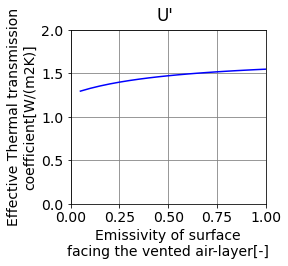

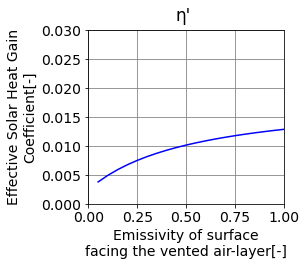

In [24]:
# 分析条件を固定
df = df_summer.query("a_surf == 0.5 & j_surf == 1000.0  & v_a == 0.5 & C_1 == 11.0")
# グラフ描画
setPltComparison_NoLegend(df=df, fig_title='U\'',
                 x_label='Emissivity of surface\nfacing the vented air-layer[-]',
                 y_label='Effective Thermal transmission\ncoefficient[W/(m2K)]',
                 x_data_name='emissivity_2', y_data_name='u_dash',
                 x_scale_interval = 0.25,
                 xlim_min=0.0, xlim_max=1.0,
                 ylim_min=0.0, ylim_max=2.0
                )
# グラフ描画
setPltComparison_NoLegend(df=df, fig_title='η\'',
                 x_label='Emissivity of surface\nfacing the vented air-layer[-]',
                 y_label='Effective Solar Heat Gain\nCoefficient[-]',
                 x_data_name='emissivity_2', y_data_name='eta_dash',
                 x_scale_interval = 0.25,
                 xlim_min=0.0, xlim_max=1.0,
                 ylim_min=0.0, ylim_max=0.03
                )